Complete the exercises below For **Assignment #5**.

In this exercise, we are building a logistic regression classification model. We'll work with the [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).  

Load the `tidymodels` library. 

In [33]:
library(tidymodels)

The data is located in your homework directory in the `diabetes.csv` file. Read in the data by running the following cell. We are "splitting" the data into training and testing sets. We will evaluate our model's performance with the test set.

In [34]:
diabetes = readr::read_csv('diabetes.csv') |> 
    mutate(Outcome = factor(Outcome))

split = initial_split(diabetes, strata = Outcome)

diabetes_train = training(split)
diabetes_test = testing(split)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Glimpse the `diabetes_train` table.

In [4]:
glimpse(diabetes_train)

Rows: 576
Columns: 9
$ Pregnancies              <dbl> 1, 1, 10, 1, 13, 5, 5, 3, 6, 10, 4, 3, 7, 7, …
$ Glucose                  <dbl> 85, 89, 115, 97, 145, 117, 109, 88, 92, 122, …
$ BloodPressure            <dbl> 66, 66, 0, 66, 82, 92, 75, 58, 92, 78, 60, 64…
$ SkinThickness            <dbl> 29, 23, 0, 15, 19, 0, 26, 11, 0, 31, 33, 25, …
$ Insulin                  <dbl> 0, 94, 0, 140, 110, 0, 0, 54, 0, 0, 192, 70, …
$ BMI                      <dbl> 26.6, 28.1, 35.3, 23.2, 22.2, 34.1, 36.0, 24.…
$ DiabetesPedigreeFunction <dbl> 0.351, 0.167, 0.134, 0.487, 0.245, 0.337, 0.5…
$ Age                      <dbl> 31, 21, 29, 22, 57, 38, 60, 22, 28, 45, 33, 2…
$ Outcome                  <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


❓ Which variable is suitable as the "outcome" in a logistic regression model?

**Answer:**

The "outcome" of the logistic regression model in this instance is the person either has diabetes (1) or does not have diabetes (0). 

❓ Navigate to [Kaggle page](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) for this dataset. Find descriptions for the `Glucose` and `BMI` columns. Add these descriptions to the [Markdown table](https://www.markdownguide.org/extended-syntax/#tables) below.

| Column name | Description |
| :---------- | :--------------------------------------------------------------------------------- |
| Glucose     | Plasma glucose concentration a 2 hours in an oral glucose tolerance test           |
| BMI         | Body mass index (weight in kg/(height in m)^2)                                     |

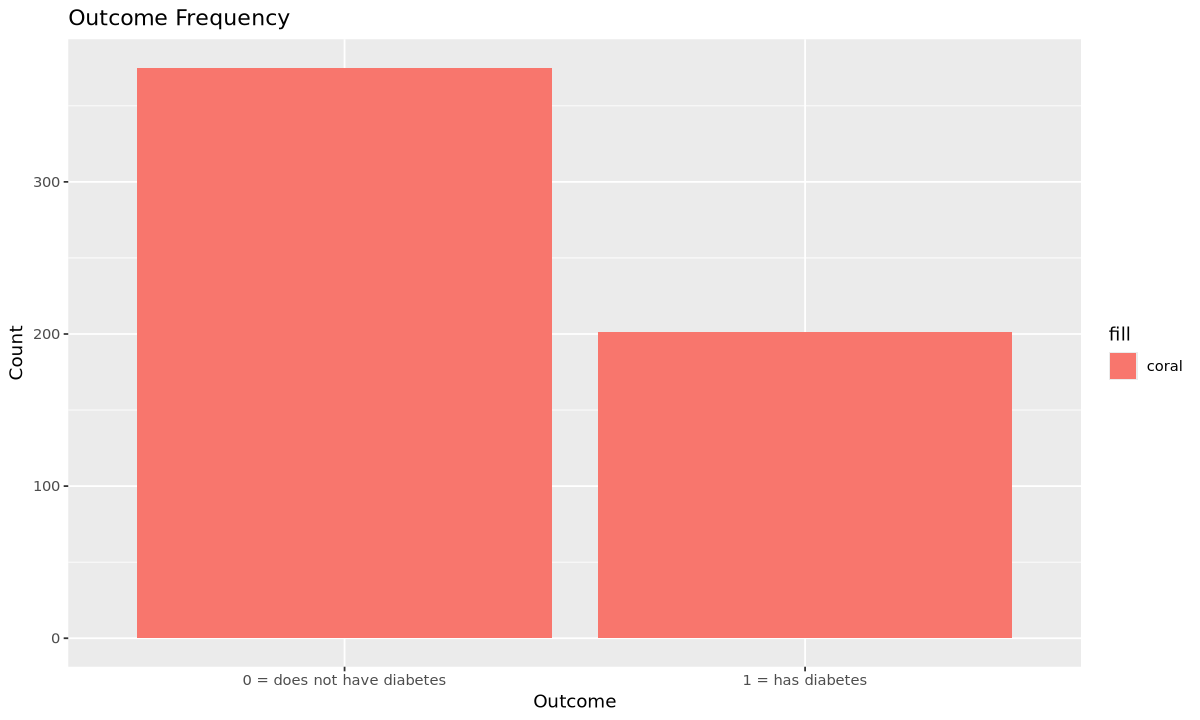

In [35]:
diabetes_train$Outcome = factor(diabetes_train$Outcome, 
                                 levels = c(0, 1),
                                 labels = c("0 = does not have diabetes", "1 = has diabetes"))

ggplot(diabetes_train, aes(x = Outcome, fill = "coral")) + 
    geom_bar() +
    labs(title = "Outcome Frequency", 
         x = "Outcome",
         y = "Count")

❓ Is the data balanced? I.e. do we have equal counts of each outcome?

**Answer:**

In [36]:
table(diabetes_train$Outcome)

outcome_counts = table(diabetes_train$Outcome)

chisq_test = chisq.test(outcome_counts)
chisq_test


0 = does not have diabetes           1 = has diabetes 
                       375                        201 


	Chi-squared test for given probabilities

data:  outcome_counts
X-squared = 52.562, df = 1, p-value = 4.168e-13


The data does not appear to be balanced, the data shows a statistically significant difference between the outcomes.

Run the code below to create a table for plotting the predictors we will use in our model: `Glucose` and `BMI`. 

In [8]:
plot_df = diabetes_train |>
    select(Outcome, Glucose, BMI) |>
    pivot_longer(cols = c(Glucose, BMI))

plot_df |> head()

Outcome,name,value
<fct>,<chr>,<dbl>
0 = does not have diabetes,Glucose,85.0
0 = does not have diabetes,BMI,26.6
0 = does not have diabetes,Glucose,89.0
0 = does not have diabetes,BMI,28.1
0 = does not have diabetes,Glucose,115.0
0 = does not have diabetes,BMI,35.3


Using `plot_df`, make a chart showing the relationship of `Glucose` and `BMI` with `Outcome`. 

- use `geom_jitter` for your "geom"
- `facet_wrap` your chart by the `name` variable. (e.g. `facet_wrap(~name, ncol = 2, scales = 'free_x')`)

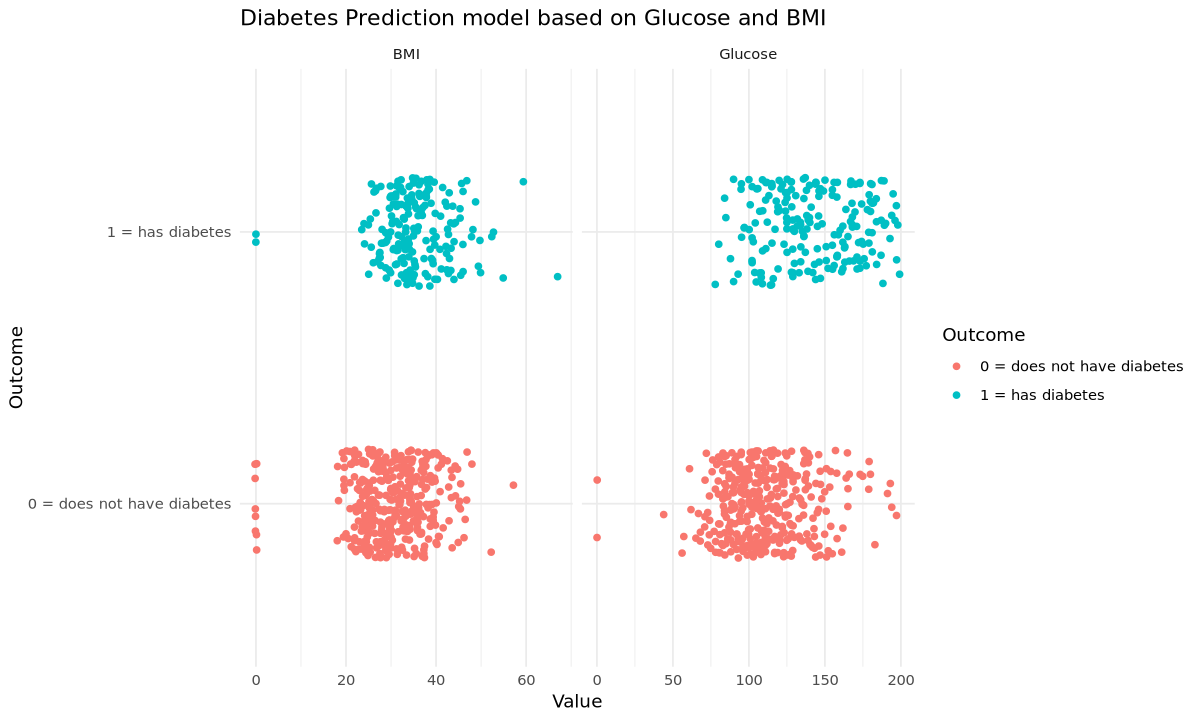

In [37]:
options(repr.plot.width = 10, repr.plot.height = 6)
plot_df = diabetes_train |>
  select(Glucose, BMI, Outcome) |>
  pivot_longer(cols = c(Glucose, BMI), names_to = "name", values_to = "value")

ggplot(plot_df, aes(x = value, y = Outcome, color = Outcome)) +
  geom_jitter(width = 0.2, height = 0.2) +
  facet_wrap(~name, ncol = 2, scales = 'free_x') +
  labs(title = "Diabetes Prediction model based on Glucose and BMI",
       x = "Value",
       y = "Outcome") +
  theme_minimal()


❓ What happens when you remove the `scales = 'free_x'` argument from the `facet_wrap` function?

**Answer:**

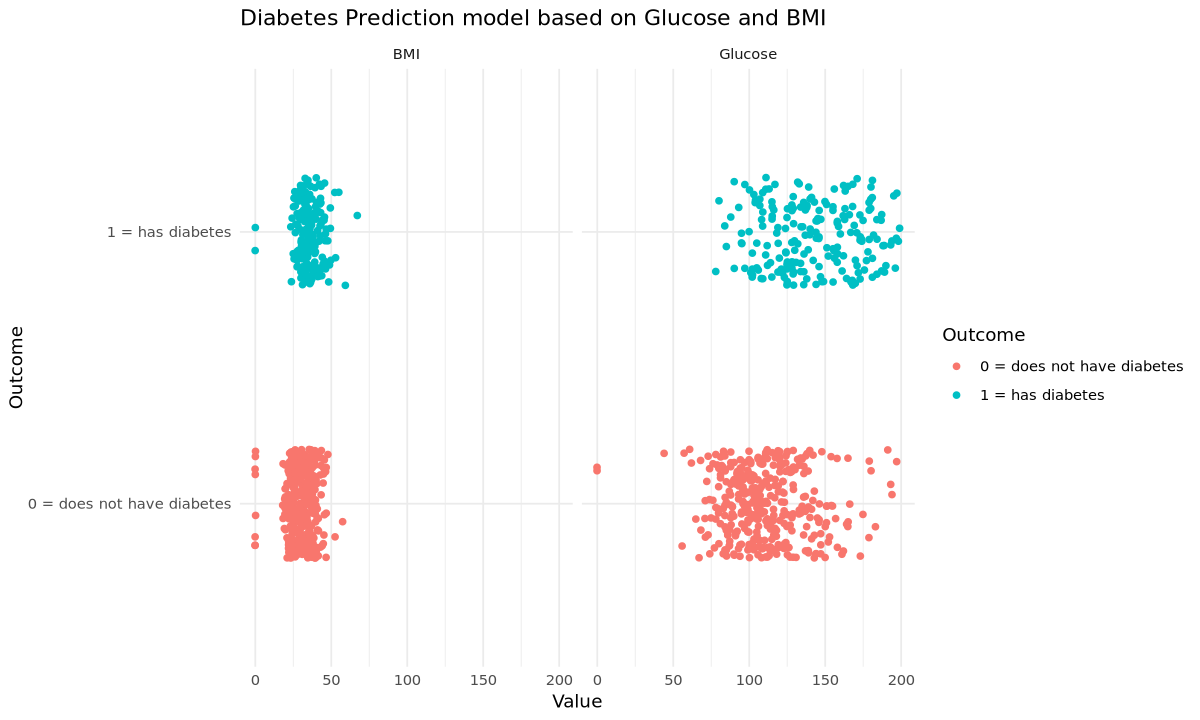

In [38]:
ggplot(plot_df, aes(x = value, y = Outcome, color = Outcome)) +
  geom_jitter(width = 0.2, height = 0.2) +
  facet_wrap(~name, ncol = 2) +
  labs(title = "Diabetes Prediction model based on Glucose and BMI",
       x = "Value",
       y = "Outcome") +
  theme_minimal()

Without the scales = 'free_x' argument in the facet_wrap function, now both BMI and Glucose are on the same x-axis scale. With the differences in the data, having the same scale makes it much more difficult to visualize the BMI data. The scales = 'free_x' allows for the differentiation in scales and easier to interpret.

Using your training data, build logistic regression model of `Outcome` with `BMI` and `Glucose` as predictors. 
- Use "glm" for you engine
- The formula for your fit function will be `Outcome ~ BMI + Glucose`

In [18]:
logistic_mod = logistic_reg() |>
  set_engine("glm")

logistic_rec = recipe(Outcome ~ BMI + Glucose, data = diabetes_train)

logistic_workflow = workflow() |>
  add_model(logistic_mod) |>
  add_recipe(logistic_rec)

logistic_fit = logistic_workflow |>
  fit(data = diabetes_train)

tidy(logistic_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.43698472,0.683508097,-10.880610,1.426062e-27
BMI,0.06775993,0.015108126,4.484999,7.291422e-06
Glucose,0.03704718,0.003839129,9.649892,4.920733e-22


Using `augment` with your fitted model and the `diabetes_test` data as arguments, create a new dataset called `diabetes_test_wPred` that is the `diabetes_test` table including predictions from your model. 

In [19]:
diabetes_test_wPred = augment(logistic_fit, new_data = diabetes_test)

print(diabetes_test_wPred)

# A tibble: 192 × 12
   .pred_class .pred_0 = does not h…¹ .pred_1 = has diabet…² Pregnancies Glucose
   <fct>                        <dbl>                  <dbl>       <dbl>   <dbl>
 1 0 = does n…                  0.803                  0.197           5     116
 2 1 = has di…                  0.127                  0.873           2     197
 3 0 = does n…                  0.693                  0.307           4     110
 4 0 = does n…                  0.611                  0.389          10     139
 5 0 = does n…                  0.813                  0.187           7     107
 6 0 = does n…                  0.665                  0.335           1     103
 7 0 = does n…                  0.697                  0.303           1     115
 8 0 = does n…                  0.526                  0.474           3     126
 9 0 = does n…                  0.797                  0.203           8      99
10 1 = has di…                  0.364                  0.636           3     158
# ℹ 182

Run the code below to generate a confusion matrix for your model predictions. 

(❗️Hint: See Table 4.4 from [*Introduction to Statistical Learning (Version 2)*](https://www.statlearning.com/) for an example confusion matrix.)

In [20]:
diabetes_test_wPred = augment(logistic_fit, new_data = diabetes_test)

diabetes_test_wPred |> conf_mat(Outcome, .pred_class)

                            Truth
Prediction                   0 = does not have diabetes 1 = has diabetes
  0 = does not have diabetes                        109               34
  1 = has diabetes                                   16               33

❓ Based on the confusion matrix above, 
- How many individuals had diabetes in your test data?
- Of those that actually had diabetes, how many were predicted to have diabetes by your model?
- How many individuals predicted to have diabetes did not have diabetes?

**Answer:**

- There are 67 individuals with diabetes in the test data. 
- 33 of the 67 were correctly predicted.
- 16 individuals were predicted to have diabetes that did not actually have diabetes (false positive).